# Why should I use Weaviate Modules?

### TLDR: Weaviate's GraphQL RAG API is `~500 times faster` compared to a Python Client Handoff

Weaviate's Modules tightly integrate inference APIs with the database's query processing.

For example, Weaviate's `generate` API parses the response from vector search, sends a direct request to an LLM API, and then parses the response.

This is orchestrated with Golang, a programming language mostly famous for it's concurrency support and applications in web servers.

This notebook will illustrated the speed differeneces between Weaviate's `generate` API with parsing a request from the python client to send to an LLM provider's python client (which we reference as DIY).

## DIY: 1.9 seconds

## Weaviate GraphQL: 4 milliseconds

In [21]:
import weaviate
from openai import OpenAI
import json

client = weaviate.connect_to_local()  # Connect with default parameters

openai_client = OpenAI(api_key = openai_api_key)

Average execution time: 1.8931033134460449 seconds 
 

Minimum execution time: 1.4569878578186035 seconds
Maximum execution time: 2.4073338508605957 seconds


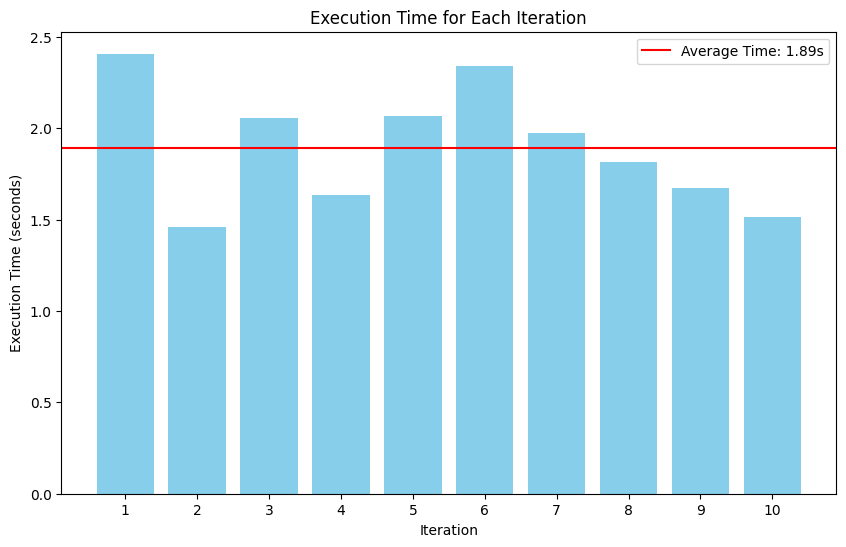

In [40]:
import time

# Initialize arrays for saving responses and times
#responses = [] #ToDo
execution_times = []

# Client setup (assuming it's already configured)
blogs = client.collections.get("WeaviateBlogChunk")

for idx in range(10):
    start = time.time()
    
    # Perform the query
    response = blogs.query.near_text(
        query="animal",
        limit=2
    )
    
    # Extract and concatenate the results
    results = []
    for o in response.objects:
        results.append(o.properties["content"])
    results_joined = "".join(results)
    
    prompt = f"{results_joined} \n Based on the context, what are cross encoders?"
    
    # Generate response using OpenAI client (assuming it's already configured)
    response = openai_client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages = [
          {
              "role": "user",
              "content": prompt
          }
      ],
      temperature=0,
      max_tokens=2048,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )
    
    # Save the response and the execution time
    execution_times.append(time.time() - start)
    #responses.append(response.choices[0].message.content), #ToDo test with higher temperature
    
# Calculate summary statistics
average_time = np.mean(execution_times)
min_time = min(execution_times)
max_time = max(execution_times)

print(f"Average execution time: {average_time} seconds \n \n")
print(f"Minimum execution time: {min_time} seconds")
print(f"Maximum execution time: {max_time} seconds")

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), execution_times, color='skyblue')
plt.xlabel('Iteration')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time for Each Iteration')
plt.xticks(range(1, 11))
plt.axhline(y=average_time, color='r', linestyle='-', label=f'Average Time: {average_time:.2f}s')
plt.legend()
plt.show()

# GraphQL API

Average execution time: 0.00417780876159668 seconds 
 

Minimum execution time: 0.001584768295288086 seconds
Maximum execution time: 0.023260116577148438 seconds


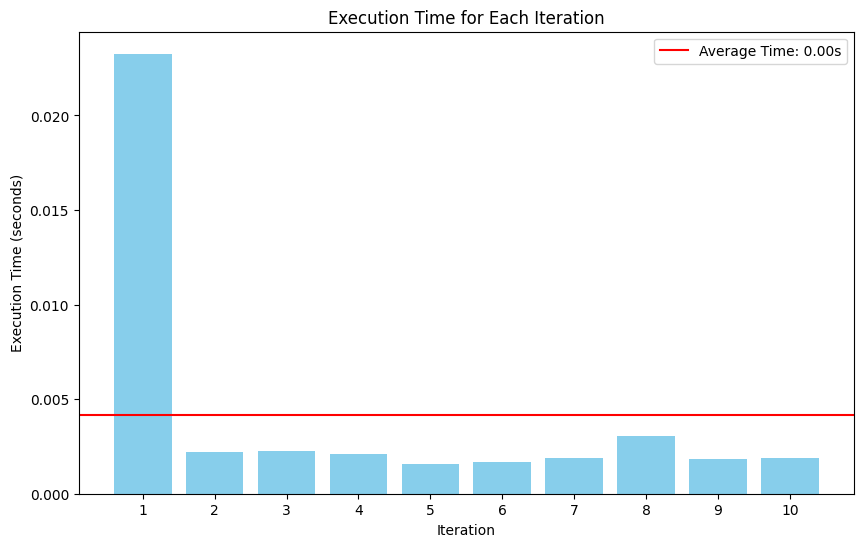

In [41]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Assuming the client setup is already done

# Initialize arrays for saving latencies
latencies = []

for _ in range(10):
    start = time.time()
    
    # Execute the GraphQL query
    response = client.graphql_raw_query("""
    {
        Get {
            WeaviateBlogChunk {
                content
                _additional {
                    generate(
                        groupedResult: {
                            task: "What are cross encoders?"
                        }
                    )
                }
            }
        }
    }
    """)
    
    # Log the latency
    latencies.append(time.time() - start)

# Calculate summary statistics
average_latency = np.mean(latencies)
min_latency = min(latencies)
max_latency = max(latencies)

print(f"Average execution time: {average_latency} seconds \n \n")
print(f"Minimum execution time: {min_latency} seconds")
print(f"Maximum execution time: {max_latency} seconds")

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), latencies, color='skyblue')
plt.xlabel('Iteration')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time for Each Iteration')
plt.xticks(range(1, 11))
plt.axhline(y=average_latency, color='r', linestyle='-', label=f'Average Time: {average_latency:.2f}s')
plt.legend()
plt.show()

In [35]:
import time

# run the same query over and over again. 
# Log the repsonses and the latencies
start = time.time()
response = client.graphql_raw_query("""
{
    Get {
        WeaviateBlogChunk {
            content
            _additional {
                generate(
                    groupedResult: {
                        task: "What are cross encoders?"
                    }
                )
            }
        }
    }
}
""")

print(f"With Modules: One RAG query ran in {time.time() - start} seconds")

With Modules: One RAG query ran in 0.030779361724853516 seconds


# WIP gRPC Test

In [9]:
blogs = client.collections.get("WeaviateBlogChunk")
start = time.time()
response = blogs.generate.near_text(
    query="What are cross encoders?",
    limit=5,
    grouped_task="What do these animals have in common?",
)

# Parsing omitted
'''
print(response.generated)  # Generated text from grouped task
for o in response.objects:
    print(o.generated)  # Generated text from single prompt
    print(o.properties)  # Object properties
'''

print(f"With Weaviate Modules: One RAG query ran in {time.time() - start} seconds")

WeaviateQueryError: Query call with protocol GRPC search failed with message explorer: get class: extend: unknown capability: generate.